In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.9 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import ee
import geemap
import geemap.colormaps as cm
import geopandas as gpd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import xgboost
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
#import rasterio
#from rasterio.transform import from_origin
#from rasterio.merge import merge
#from rasterio.enums import Resampling
import os
import joblib
import pickle
import optuna
import shap
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

data_dir = r"/content/drive/MyDrive/Updated_Bihar/Updated_Points"

## **Read the Dataset**

In [ ]:
# Import Training and Testing Dataset:
df = gpd.read_file(os.path.join(data_dir, "Updated_sample_data.shp"))
df.drop(columns=['geometry'], inplace=True)
print(df.shape)
df.head()

(10075, 21)


,Aspect,Dist_to_Dr,Dist_to_Ro,Drainage_D,Elevation,Flow_Accum,HAND_30_10,LULC,Lithology,Mean_Monso,...,Plan_Curve,Pop_Densit,Profile_Cu,Road_Densi,SPI,STI,Slope,Soil,TWI,flood
0,-1.000000,150.000000,12601.286133,1.506197,89,0.000000,0.0,4,14,873.882446,...,0.000000,1273.598999,0.000000,0.000000,0.000000,0,0.000000,16,11.015802,1
1,225.000000,60.000000,4234.571777,1.452017,46,0.000000,3.0,4,13,1125.117310,...,0.108108,1148.549805,-0.108108,0.077553,0.000000,0,0.666018,3,7.869520,1
2,143.130096,240.000000,5038.303223,1.363731,105,3.433987,1.0,4,14,906.967712,...,-0.058212,566.845703,0.049896,0.055640,1.425195,3,2.682963,18,7.168621,1
3,0.000000,247.386337,2610.172363,1.736187,53,0.000000,4.0,4,13,948.148254,...,0.000000,1849.163574,-0.108108,0.077412,0.000000,0,0.941849,10,7.522947,1
4,-1.000000,60.000000,19587.152344,1.483128,47,4.941642,2.0,4,13,989.463196,...,0.000000,1323.467896,0.000000,0.000000,0.000000,377,0.000000,4,15.428600,1


In [ ]:
cols_renamed = {
    'Dist_to_Dr': 'Dist_to_Drain',
    'Dist_to_Ro': 'Dist_to_Road',
    'Drainage_D': 'Drainage_Density',
    'Flow_Accum': 'Flow_Accumulation',
    'HAND_30_10': 'HAND_30_100',
    'Mean_Monso': 'Mean_Monsoon_Rainfall',
    'Pop_Densit': 'Pop_Density',
    'Profile_Cu': 'Profile_Curve',
    'Road_Densi': 'Road_Density'
}
df.rename(columns=cols_renamed, inplace=True)

In [ ]:
num_bands = ['Elevation', 'Slope', 'Aspect', 'Profile_Curve', 'NDVI', 'Plan_Curve', 'TWI', 'SPI', 'STI',
             'Flow_Accumulation', 'Drainage_Density', 'Dist_to_Drain','Pop_Density','Road_Density',
             'HAND_30_100', 'Dist_to_Road','Mean_Monsoon_Rainfall']

cat_bands = ['LULC', 'Lithology', 'Soil']

band_names = num_bands + cat_bands
print(len(band_names))

df = df[band_names + ['flood']]
print(df.shape)
df.head()

20
(10075, 21)


,Elevation,Slope,Aspect,Profile_Curve,NDVI,Plan_Curve,TWI,SPI,STI,Flow_Accumulation,...,Dist_to_Drain,Pop_Density,Road_Density,HAND_30_100,Dist_to_Road,Mean_Monsoon_Rainfall,LULC,Lithology,Soil,flood
0,89,0.000000,-1.000000,0.000000,0.215334,0.000000,11.015802,0.000000,0,0.000000,...,150.000000,1273.598999,0.000000,0.0,12601.286133,873.882446,4,14,16,1
1,46,0.666018,225.000000,-0.108108,0.139333,0.108108,7.869520,0.000000,0,0.000000,...,60.000000,1148.549805,0.077553,3.0,4234.571777,1125.117310,4,13,3,1
2,105,2.682963,143.130096,0.049896,0.201097,-0.058212,7.168621,1.425195,3,3.433987,...,240.000000,566.845703,0.055640,1.0,5038.303223,906.967712,4,14,18,1
3,53,0.941849,0.000000,-0.108108,0.167796,0.000000,7.522947,0.000000,0,0.000000,...,247.386337,1849.163574,0.077412,4.0,2610.172363,948.148254,4,13,10,1
4,47,0.000000,-1.000000,0.000000,0.163737,0.000000,15.428600,0.000000,377,4.941642,...,60.000000,1323.467896,0.000000,2.0,19587.152344,989.463196,4,13,4,1


## **Train Test Split**

In [ ]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1],
    df['flood'],
    test_size=0.3,
    random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7052, 20) (3023, 20) (7052,) (3023,)


In [ ]:
y_train.value_counts()

,count
flood,
0,3596
1,3456


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7052 entries, 9701 to 7270
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Elevation              7052 non-null   int64  
 1   Slope                  7052 non-null   float64
 2   Aspect                 7052 non-null   float64
 3   Profile_Curve          7052 non-null   float64
 4   NDVI                   7052 non-null   float64
 5   Plan_Curve             7052 non-null   float64
 6   TWI                    7052 non-null   float64
 7   SPI                    7052 non-null   float64
 8   STI                    7052 non-null   int64  
 9   Flow_Accumulation      7052 non-null   float64
 10  Drainage_Density       7052 non-null   float64
 11  Dist_to_Drain          7052 non-null   float64
 12  Pop_Density            7052 non-null   float64
 13  Road_Density           7052 non-null   float64
 14  HAND_30_100            7052 non-null   float64
 15  Dist_t

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

# List of variables you want to visualize
variables = [
    "Elevation", "Slope", "Aspect", "Profile_Curve", "NDVI",
    "Plan_Curve", "TWI", "SPI", "STI", "Flow_Accumulation",
    "Drainage_Density", "Dist_to_Drain", "Pop_Density",
    "Road_Density", "HAND_30_100", "Dist_to_Road",
    "Mean_Monsoon_Rainfall"
]

scaler = StandardScaler()

for var in variables:
    arr = gdf[var].values.reshape(-1, 1)   # if gdf contains your variables
    arr_scaled = scaler.fit_transform(arr).flatten()

    gdf[var + "_std"] = arr_scaled

    # Side-by-side maps
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    gdf.plot(column=var, cmap="viridis", ax=axes[0], legend=True)
    axes[0].set_title(f"{var} (Original)")

    gdf.plot(column=var + "_std", cmap="coolwarm", ax=axes[1], legend=True)
    axes[1].set_title(f"{var} (Standardized)")

    plt.tight_layout()
    plt.show()

NameError: name 'gdf' is not defined

## **Feature Engineering**

In [ ]:
# # Define the column transformer
transformer = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), num_bands),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_bands)
    ], remainder='passthrough'
)

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

out_column_names = [col.split("__")[-1] for col in transformer.get_feature_names_out()]
X_train_transformed = pd.DataFrame(X_train_transformed, columns=out_column_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=out_column_names)

print(X_train_transformed.shape, X_test_transformed.shape)

(7052, 51) (3023, 51)


In [ ]:
# Save the column transformer
# with open("/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/transformer.pkl", "wb") as f:
#     pickle.dump(transformer, f)

## **Apply Feature Selection**

<Axes: >

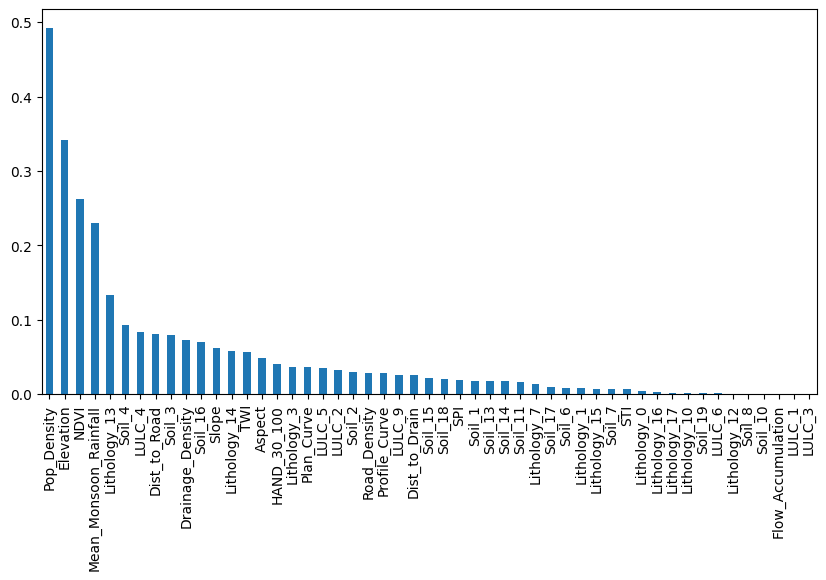

In [ ]:
mutual_info = mutual_info_classif(X_train_transformed, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_transformed.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 5))

In [ ]:
# mutual_info.to_csv(os.path.join(data_dir, 'updated_mutual_info_feature_selection.csv'))

In [ ]:
# Select columns where any value is greater than 0
# col_to_keep = mutual_info[mutual_info>0].index
selected_features = [
       'Elevation', 'Slope', 'Aspect', 'Profile_Curve', 'NDVI', 'Plan_Curve',
       'TWI', 'SPI', 'STI', 'Drainage_Density', 'Dist_to_Drain', 'Pop_Density',
       'Road_Density', 'HAND_30_100', 'Dist_to_Road', 'Mean_Monsoon_Rainfall',
       'LULC_2', 'LULC_4', 'LULC_5', 'LULC_6', 'LULC_9', 'Lithology_0',
       'Lithology_1', 'Lithology_3', 'Lithology_7', 'Lithology_10',
       'Lithology_12', 'Lithology_13', 'Lithology_14', 'Lithology_15',
       'Lithology_16', 'Lithology_17', 'Soil_1', 'Soil_2', 'Soil_3', 'Soil_4',
       'Soil_6', 'Soil_7', 'Soil_8', 'Soil_10', 'Soil_11', 'Soil_13',
       'Soil_14', 'Soil_15', 'Soil_16', 'Soil_17', 'Soil_18', 'Soil_19'
]
X_train = X_train_transformed[selected_features]
X_test = X_test_transformed[selected_features]

In [ ]:
# # X_train.to_csv('/content/drive/MyDrive/Bihar Project Work/Datasets/CSVs/updated_Training_data.csv', index=False)
# # X_test.to_csv('/content/drive/MyDrive/Bihar Project Work/Datasets/CSVs/updated_Testing_data.csv', index=False)
# y_train.to_csv('/content/drive/MyDrive/Bihar Project Work/Datasets/CSVs/updated_y_train_data.csv', index=False)
# y_test.to_csv('/content/drive/MyDrive/Bihar Project Work/Datasets/CSVs/updated_y_test_data.csv', index=False)

# **Random Forest**

In [ ]:
def rf_objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # keep it lower to add variability
        "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy']),
        "max_depth": trial.suggest_int("max_depth", 2, 5),  # shallower trees = less confident
        "min_samples_split": trial.suggest_int("min_samples_split", 20, 100),  # avoid small splits
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 30, 100),  # ensure leaf has enough data
        "max_features": trial.suggest_float("max_features", 0.05, 0.5),  # limit features = more varied trees
        "bootstrap": True
    }

    rf_model = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)

    rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')  # or 'neg_log_loss'
    return np.mean(rf_cv_scores)


In [ ]:
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=30)

[I 2025-07-28 09:06:41,928] A new study created in memory with name: no-name-be929da6-9f91-4537-b68f-aae06699520b
[I 2025-07-28 09:06:44,450] Trial 0 finished with value: 0.9249851470965214 and parameters: {'n_estimators': 66, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 21, 'min_samples_leaf': 91, 'max_features': 0.13056811784041777}. Best is trial 0 with value: 0.9249851470965214.
[I 2025-07-28 09:06:49,855] Trial 1 finished with value: 0.9286721856135429 and parameters: {'n_estimators': 109, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 31, 'min_samples_leaf': 43, 'max_features': 0.27426807002038633}. Best is trial 1 with value: 0.9286721856135429.
[I 2025-07-28 09:06:56,714] Trial 2 finished with value: 0.9248437052339522 and parameters: {'n_estimators': 193, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 70, 'min_samples_leaf': 91, 'max_features': 0.2678088215173585}. Best is trial 1 with value: 0.9286721856135429.
[I 2025-07-28 09:06:59,2

In [ ]:
rf_best_params = rf_study.best_params
rf_best_params

{'n_estimators': 79,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 87,
 'min_samples_leaf': 35,
 'max_features': 0.39198276397961707}

In [ ]:
rf_params = {'n_estimators': 79,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 87,
 'min_samples_leaf': 35,
 'max_features': 0.39198276397961707}

rf_model = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)
rf_model = rf_model.fit(X_train, y_train)
rf_model

RandomForestClassifier(max_depth=5, max_features=0.39198276397961707,
                       min_samples_leaf=35, min_samples_split=87,
                       n_estimators=79, n_jobs=-1, random_state=42)

In [ ]:
# # previous params :
# {'n_estimators': 321,
#  'criterion': 'entropy',
#  'max_depth': 18,
#  'min_samples_split': 72,
#  'min_samples_leaf': 3,
#  'max_features': 0.535611257348088}

# # Updated Params:
# {'n_estimators': 237,
#  'criterion': 'entropy',
#  'max_depth': 20,
#  'min_samples_split': 31,
#  'min_samples_leaf': 8,
#  'max_features': 0.3692907530270838}

In [ ]:
# rf_model = RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1)
# rf_model = rf_model.fit(X_train, y_train)
# rf_model

In [ ]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]


<Axes: ylabel='Count'>

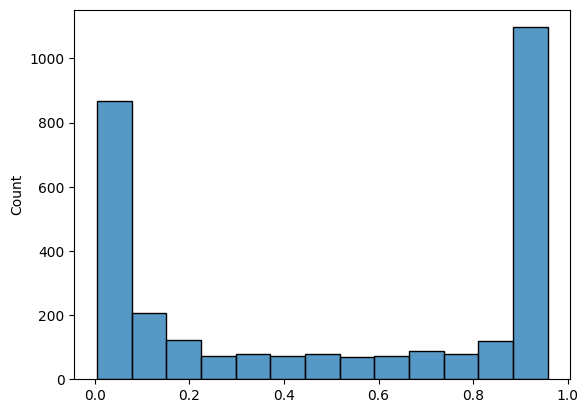

In [ ]:
sns.histplot(y_pred_proba)

In [ ]:
train_preds = rf_model.predict(X_train)
test_preds = rf_model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

Training Accuracy: 0.9388825865002836
Testing Accuracy: 0.9232550446576249


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1480
           1       0.92      0.93      0.92      1543

    accuracy                           0.92      3023
   macro avg       0.92      0.92      0.92      3023
weighted avg       0.92      0.92      0.92      3023



In [ ]:
out_path = "/content/drive/MyDrive/Bihar Project Work/ML_Models/"

with open(os.path.join(out_path, "updated_Random_Forest.pkl"), "wb") as f:
    pickle.dump(rf_model, f)

# **XGboost**

In [ ]:
def xgb_objective(trial):
    xgb_param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
    }

    xgb_model = XGBClassifier(**xgb_param, random_state=42, n_jobs=-1)


    # Perform 5-fold cross-validation and take the mean accuracy as score
    xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
    xgb_score = np.mean(xgb_cv_scores)

    return xgb_score

In [ ]:
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=30)

[I 2025-07-28 04:11:10,754] A new study created in memory with name: no-name-b1f78316-f31e-4451-9ceb-19ba89678668
[I 2025-07-28 04:11:14,981] Trial 0 finished with value: 0.9588773114988113 and parameters: {'n_estimators': 642, 'max_depth': 10, 'learning_rate': 0.26897008872733374, 'subsample': 0.6250454983033307, 'colsample_bytree': 0.6365112304366409, 'gamma': 0.1809942572896578}. Best is trial 0 with value: 0.9588773114988113.
[I 2025-07-28 04:11:22,788] Trial 1 finished with value: 0.9581676895315934 and parameters: {'n_estimators': 604, 'max_depth': 16, 'learning_rate': 0.24727325643893824, 'subsample': 0.9059415523452392, 'colsample_bytree': 0.6971083742493768, 'gamma': 1.6119805594229168}. Best is trial 0 with value: 0.9588773114988113.
[I 2025-07-28 04:11:52,079] Trial 2 finished with value: 0.9550484290101583 and parameters: {'n_estimators': 762, 'max_depth': 13, 'learning_rate': 0.011095649621197433, 'subsample': 0.5065104830115021, 'colsample_bytree': 0.8804908965234952, 'ga

In [ ]:
xgb_best_params = xgb_study.best_params
xgb_best_params

{'n_estimators': 984,
 'max_depth': 14,
 'learning_rate': 0.044327762321999406,
 'subsample': 0.7211262454061391,
 'colsample_bytree': 0.9285993064069485,
 'gamma': 0.5730387895826239}

In [ ]:
# # Preious params:
# {'n_estimators': 777,
#  'max_depth': 14,
#  'learning_rate': 0.09350810152807976,
#  'subsample': 0.7628905792198585,
#  'colsample_bytree': 0.8367026540862497,
#  'gamma': 0.11729225846803726}

# # Updated params:
# {'n_estimators': 984,
#  'max_depth': 14,
#  'learning_rate': 0.044327762321999406,
#  'subsample': 0.7211262454061391,
#  'colsample_bytree': 0.9285993064069485,
#  'gamma': 0.5730387895826239}

In [ ]:
xgb_model = XGBClassifier(**xgb_best_params, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9285993064069485, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.5730387895826239, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.044327762321999406,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=984, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
xgb_y_pred = xgb_model.predict(X_test)

In [ ]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1480
           1       0.96      0.95      0.95      1543

    accuracy                           0.95      3023
   macro avg       0.95      0.95      0.95      3023
weighted avg       0.95      0.95      0.95      3023



In [ ]:
model_output_path = '/content/drive/MyDrive/Bihar Project Work/ML_Models/'
joblib.dump(xgb_model, out_path + 'updated_XGBoost.pkl')

['/content/drive/MyDrive/Bihar Project Work/ML_Models/updated_XGBoost.pkl']

# **ExtraTrees**

In [ ]:
def et_objective(trial):
    # Define hyperparameters to be tuned
    et_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "criterion": trial.suggest_categorical("criterion", ['gini', "entropy", "log_loss"]),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0),
    }


    # Initialize the classifier with the trial parameters
    et_model = ExtraTreesClassifier(**et_params, random_state=42, n_jobs=-1)

    # Perform 5-fold cross-validation and take the mean accuracy as score
    et_cv_scores = cross_val_score(et_model, X_train, y_train, cv=5, scoring='accuracy')
    et_score = np.mean(et_cv_scores)

    return et_score


In [ ]:
# Run the study
et_study = optuna.create_study(direction='maximize')
et_study.optimize(et_objective, n_trials=30)

[I 2025-04-23 02:28:27,290] A new study created in memory with name: no-name-25610490-aa11-4300-8001-1a90771659d2
[I 2025-04-23 02:28:33,042] Trial 0 finished with value: 0.8282656897185079 and parameters: {'n_estimators': 152, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 21, 'min_samples_leaf': 12, 'max_features': 0.8349136466562369}. Best is trial 0 with value: 0.8282656897185079.
[I 2025-04-23 02:28:56,073] Trial 1 finished with value: 0.7843671430425438 and parameters: {'n_estimators': 719, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 32, 'min_samples_leaf': 43, 'max_features': 0.5744813366475678}. Best is trial 0 with value: 0.8282656897185079.
[I 2025-04-23 02:29:12,323] Trial 2 finished with value: 0.7661258037055694 and parameters: {'n_estimators': 820, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 50, 'max_features': 0.22429383779717596}. Best is trial 0 with value: 0.8282656897185079.
[I 2025-04-23 02:29:13,5

In [ ]:
# Train final model with best parameters
et_best_model = ExtraTreesClassifier(**et_study.best_params, random_state=42, n_jobs=-1)
et_best_model.fit(X_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=19,
                     max_features=0.877781941195979, min_samples_leaf=2,
                     min_samples_split=39, n_estimators=987, n_jobs=-1,
                     random_state=42)

In [ ]:
et_best_params = et_study.best_params
et_best_params

{'n_estimators': 987,
 'criterion': 'entropy',
 'max_depth': 19,
 'min_samples_split': 39,
 'min_samples_leaf': 2,
 'max_features': 0.877781941195979}

In [ ]:
# Predict and evaluate
et_y_pred = et_best_model.predict(X_test)
print(classification_report(y_test, et_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1256
           1       0.91      0.87      0.89      1634

    accuracy                           0.88      2890
   macro avg       0.87      0.88      0.87      2890
weighted avg       0.88      0.88      0.88      2890



In [ ]:
model_output_path = "/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/"
joblib.dump(et_best_model, model_output_path + 'ExtraTrees.pkl')

["/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/ExtraTrees.pkl"]

# **Adaboost**

In [ ]:
def adb_objective(trial):
    adb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1.0),
        "algorithm": trial.suggest_categorical("algorithm", ["SAMME"])
    }

    adb_model = AdaBoostClassifier(**adb_params, random_state=42)

    # 5-fold cross-validation
    adb_cv_scores = cross_val_score(adb_model, X_train, y_train, cv=5, scoring='accuracy')
    adb_score = np.mean(adb_cv_scores)

    return adb_score

In [ ]:
# Run the study
adb_study = optuna.create_study(direction='maximize')
adb_study.optimize(adb_objective, n_trials=30)

[I 2025-04-23 08:35:37,845] A new study created in memory with name: no-name-9fce8117-49f1-4870-b25b-a5b2a9e43c79
[I 2025-04-23 08:35:52,264] Trial 0 finished with value: 0.7769538046646269 and parameters: {'n_estimators': 170, 'learning_rate': 0.5483396989493725, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.7769538046646269.
[I 2025-04-23 08:37:02,329] Trial 1 finished with value: 0.7971202979237285 and parameters: {'n_estimators': 868, 'learning_rate': 0.572579144372179, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.7971202979237285.
[I 2025-04-23 08:37:52,950] Trial 2 finished with value: 0.7916338732064416 and parameters: {'n_estimators': 735, 'learning_rate': 0.4631027047159906, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.7971202979237285.
[I 2025-04-23 08:38:41,983] Trial 3 finished with value: 0.7968236720023404 and parameters: {'n_estimators': 726, 'learning_rate': 0.5804228014568616, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.7971202979237285.

In [ ]:
adb_best_params = adb_study.best_params
adb_best_params

{'n_estimators': 924,
 'learning_rate': 0.9953742247280801,
 'algorithm': 'SAMME'}

In [ ]:
# Train final model with best parameters
adb_best_model = AdaBoostClassifier(**adb_study.best_params)
adb_best_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.9953742247280801,
                   n_estimators=924)

In [ ]:
# Predict and evaluate
adb_y_pred = adb_best_model.predict(X_test)
print(classification_report(y_test, adb_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1256
           1       0.81      0.85      0.83      1634

    accuracy                           0.80      2890
   macro avg       0.80      0.80      0.80      2890
weighted avg       0.80      0.80      0.80      2890



In [ ]:
model_output_path = "/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/"
joblib.dump(adb_best_model, model_output_path + 'Adaboost.pkl')

["/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/Adaboost.pkl"]

# **SVM**

In [ ]:
# Define objective function
def svm_objective(trial):
    svm_params = {
        "C": trial.suggest_float("C", 0.1, 4),
        "kernel": trial.suggest_categorical("kernel", ['linear', 'rbf', 'poly']),
        "gamma": trial.suggest_float("gamma", 0.01, 1)
    }

    # Pipeline with scaling (important for SVM!)
    svm_model = make_pipeline(
        SVC(**svm_params, probability=True)
    )

    # 3-fold CV for faster testing
    cv_score = cross_val_score(svm_model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return np.mean(cv_score)

In [ ]:
# Run the study
sampler = optuna.samplers.TPESampler(seed=42)
svm_study = optuna.create_study(direction='maximize')

# Run optimization with parallel processing
svm_study.optimize(svm_objective, n_trials=30, n_jobs=-1)  # 30 mins timeout

[I 2025-04-23 09:32:06,838] A new study created in memory with name: no-name-4dae7579-e8fa-43eb-bf77-659d0cf7c742
[I 2025-04-23 09:37:54,952] Trial 1 finished with value: 0.6879723907611625 and parameters: {'C': 3.2964147647461273, 'kernel': 'linear', 'gamma': 0.21578136841327167}. Best is trial 1 with value: 0.6879723907611625.
[I 2025-04-23 09:42:06,696] Trial 0 finished with value: 0.7696860609189741 and parameters: {'C': 3.992864987750891, 'kernel': 'poly', 'gamma': 0.707055416471908}. Best is trial 0 with value: 0.7696860609189741.
[I 2025-04-23 09:42:54,699] Trial 2 finished with value: 0.7928209670360534 and parameters: {'C': 2.97165755815799, 'kernel': 'poly', 'gamma': 0.32415206561289517}. Best is trial 2 with value: 0.7928209670360534.
[I 2025-04-23 09:50:27,921] Trial 3 finished with value: 0.7704274606817262 and parameters: {'C': 3.647585921068039, 'kernel': 'poly', 'gamma': 0.5828989829560358}. Best is trial 2 with value: 0.7928209670360534.
[I 2025-04-23 09:51:09,489] Tri

In [ ]:
svm_best_model = SVC(**svm_study.best_params, random_state=42, probability=True)
svm_best_model.fit(X_train, y_train)

NameError: name 'svm_study' is not defined

In [ ]:
svm_best_params = svm_study.best_params
svm_best_params

{'C': 2.617588482733055, 'kernel': 'rbf', 'gamma': 0.11321510903649369}

In [ ]:
# Predict and evaluate
svm_y_pred = svm_best_model.predict(X_test)
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1256
           1       0.85      0.85      0.85      1634

    accuracy                           0.83      2890
   macro avg       0.83      0.83      0.83      2890
weighted avg       0.83      0.83      0.83      2890



## **Fit SVM with best params**

In [ ]:
# Your best parameters from Optuna
svm_best_params = {'C': 2.617588482733055, 'kernel': 'rbf', 'gamma': 0.11321510903649369}

# Create and fit the new SVM model
svm_best_model = SVC(**svm_best_params, random_state=42, probability=True)  # Set probability=True
svm_best_model.fit(X_train, y_train)

SVC(C=2.617588482733055, gamma=0.11321510903649369, probability=True,
    random_state=42)

In [ ]:
# Predict and evaluate
svm_y_pred = svm_best_model.predict(X_test)
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1256
           1       0.85      0.85      0.85      1634

    accuracy                           0.83      2890
   macro avg       0.83      0.83      0.83      2890
weighted avg       0.83      0.83      0.83      2890



In [ ]:
model_output_path = "/content/drive/MyDrive/Bihar Project Work/ML_Models/"
joblib.dump(svm_best_model, model_output_path + 'SVM.pkl')

['/content/drive/MyDrive/Bihar Project Work/ML_Models/SVM.pkl']

# **Apply Stacking Ensemble**

In [ ]:
# load the models
# Adaboost_Model = pickle.load(open("/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/Adaboost.pkl", 'rb'))
# Extra_Trees_Model = pickle.load(open("/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/ExtraTrees.pkl", 'rb'))
# Random_Forest_Model = pickle.load(open("/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/Random_Forest.pkl", 'rb'))
# SVM_Model = pickle.load(open("/content/drive/MyDrive/Harish's Dissertation/Bihar Project Work/ML_Models/SVM.pkl", 'rb'))
# XGBoost_Model = pickle.load(open('/content/drive/MyDrive/Harish's DissertationBihar Project Work/ML_Models/XGBoost.pkl', 'rb'))

Adaboost_Model = joblib.load(open("/content/drive/MyDrive/Bihar Project Work/ML_Models/Adaboost.pkl", 'rb'))
Extra_Trees_Model = joblib.load(open("/content/drive/MyDrive/Bihar Project Work/ML_Models/ExtraTrees.pkl", 'rb'))
Random_Forest_Model = joblib.load(open("/content/drive/MyDrive/Bihar Project Work/ML_Models/Random_Forest.pkl", 'rb'))
SVM_Model = joblib.load(open("/content/drive/MyDrive/Bihar Project Work/ML_Models/SVM.pkl", 'rb'))
XGBoost_Model = joblib.load(open("/content/drive/MyDrive/Bihar Project Work/ML_Models/XGBoost.pkl", 'rb'))

In [ ]:
# Define the stacking classifier
estimators=[
        ('adb', Adaboost_Model),
        ('et', Extra_Trees_Model),
        ('rf', Random_Forest_Model),
        ('svm', SVM_Model),
        ('xgb', XGBoost_Model)
    ]

# # Stack all the models with StackClassifier
stacking_classifier = StackingClassifier(estimators,
                                         final_estimator=LogisticRegression(),
                                         cv=StratifiedKFold(3))

# Fit the training data
stacking_classifier.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=3,
        random_state=RandomState(MT19937) at 0x7B9AA387DC40, shuffle=False),
                   estimators=[('adb',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   learning_rate=0.9953742247280801,
                                                   n_estimators=924)),
                               ('et',
                                ExtraTreesClassifier(criterion='entropy',
                                                     max_depth=19,
                                                     max_features=0.877781941195979,
                                                     min_samples_leaf=2,
                                                     min_samples_split=...
                                              interaction_constraints=None,
                                              learning_rate=0.09350810152807976,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=14,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=777, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

In [ ]:
# Predict
stack_y_pred = stacking_classifier.predict(X_test)

print("Stacked Model Accuracy:", classification_report(y_test, stack_y_pred))

Stacked Model Accuracy:               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1256
           1       0.91      0.88      0.90      1634

    accuracy                           0.89      2890
   macro avg       0.88      0.89      0.89      2890
weighted avg       0.89      0.89      0.89      2890



In [ ]:
# joblib.dump(stacking_classifier, "/content/drive/MyDrive/Bihar Project Work/ML_Models/Stacked_Ensemble.pkl")

['/content/drive/MyDrive/Bihar Project Work/ML_Models/Stacked_Ensemble.pkl']

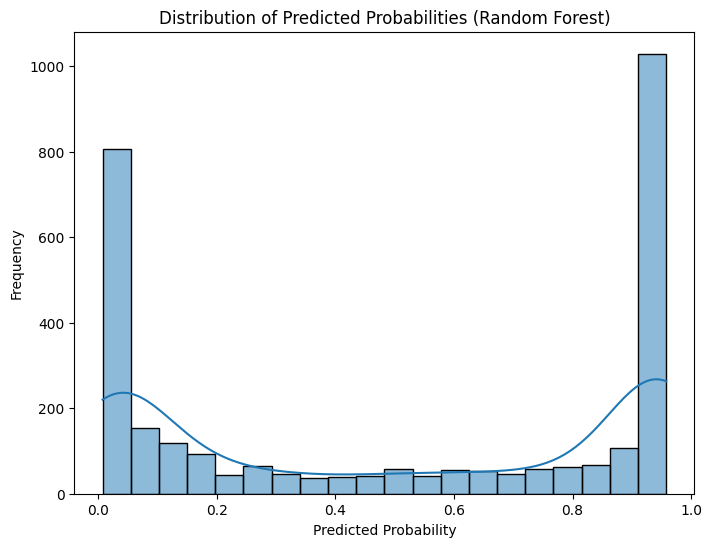

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.title('Distribution of Predicted Probabilities (Random Forest)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Get feature importances from the trained Random Forest model
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
feature_importances.plot.bar()
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()